2024-05-22 02:18:48.268590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 02:18:48.390489: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


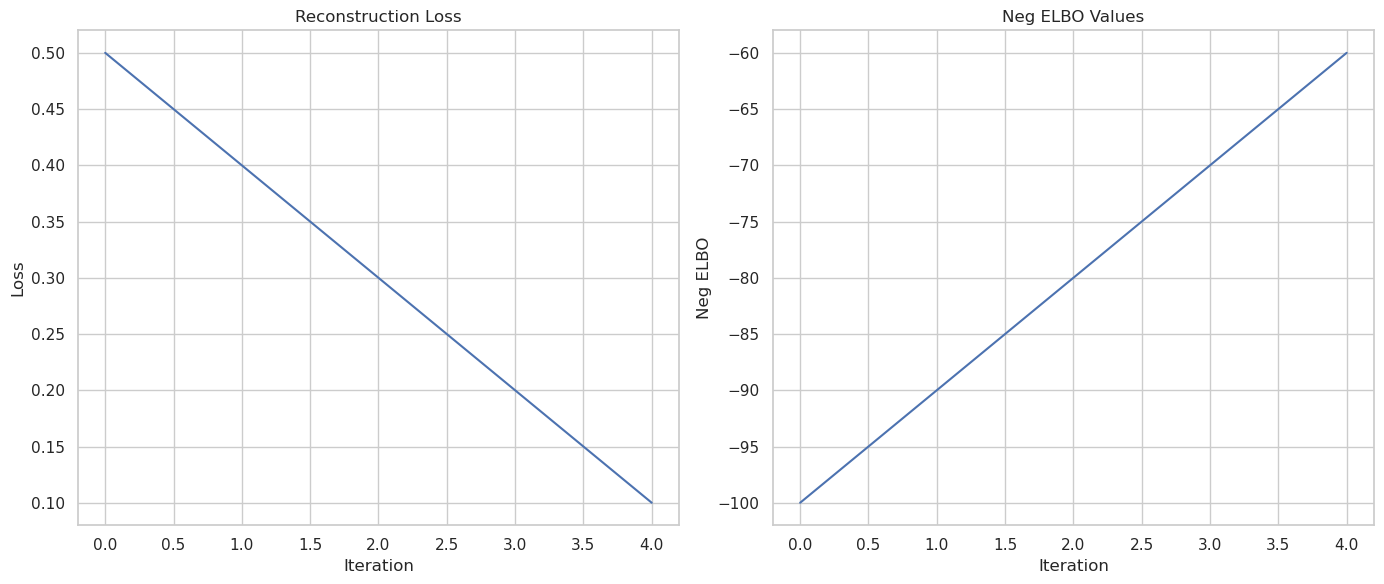

In [1]:
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean, ZeroMean
from gpytorch.mlls import VariationalELBO
from gpytorch.mlls.added_loss_term import AddedLossTerm
from gpytorch.models import ApproximateGP
from gpytorch.priors import NormalPrior, MultivariateNormalPrior
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn
from torch.distributions import kl_divergence
from tqdm import trange
from utils.data_generator import DataGenerator
from utils.myutils import Utils
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.pyplot as plt
import seaborn as sns

def plot_recon_elbo(recon_list, elbo_list, save_path=None):
    """
    Plots the reconstruction loss and ELBO values side by side using Seaborn line plots.

    Parameters:
    recon_list (list): List of reconstruction loss values.
    elbo_list (list): List of ELBO values.
    save_path (str, optional): Path to save the figure. If None, the figure is not saved.
    """
    sns.set(style="whitegrid")

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the reconstruction loss
    sns.lineplot(ax=axes[0], x=range(len(recon_list)), y=recon_list)
    axes[0].set_title("Reconstruction Loss")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Loss")

    # Plot the ELBO values
    sns.lineplot(ax=axes[1], x=range(len(elbo_list)), y=elbo_list)
    axes[1].set_title("Neg ELBO Values")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Neg ELBO")

    # Adjust layout
    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

    # Show the plots
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Example data
    recon_list = [0.5, 0.4, 0.3, 0.2, 0.1]
    elbo_list = [-100, -90, -80, -70, -60]

    plot_recon_elbo(recon_list, elbo_list, save_path="recon_elbo_plot.png")



datagenerator = DataGenerator()  # data generator
utils = Utils()  # utils function


class BayesianGPLVM(ApproximateGP):
    def __init__(self, X, variational_strategy):
        super(BayesianGPLVM, self).__init__(variational_strategy)
        self.X = X

    def forward(self):
        raise NotImplementedError

    def sample_latent_variable(self, *args, **kwargs):
        sample = self.X(*args, **kwargs)
        return sample

    def predict_latent(self, Y_test):
        mu_star = self.X.mu(Y_test)
        sigma_star = self.X.sigma(Y_test)
        return mu_star, sigma_star

    def reconstruct_y(self, Y):
        y_pred = self(self.X.mu(Y))
        y_pred_mean = y_pred.loc.detach()
        y_pred_covar = y_pred.covariance_matrix.detach()
        return y_pred_mean, y_pred_covar

    def get_X_mean(self, Y):
        return self.X.mu(Y).detach()

    def get_X_scales(self, Y):
        return np.array([torch.sqrt(x.diag()) for x in self.X.sigma(Y).detach()])

    def store(self, losses, likelihood):
        self.losses = losses
        self.likelihood = likelihood

In [2]:
class LatentVariable(gpytorch.Module):
    """
    :param n (int): Size of the latent space.
    :param latent_dim (int): Dimensionality of latent space.

    """

    def __init__(self, n, dim):
        super().__init__()
        self.n = n
        self.latent_dim = dim

    def forward(self, x):
        raise NotImplementedError

    def reset(self):
        raise NotImplementedError


class NNEncoder(LatentVariable):
    def __init__(self, n, latent_dim, prior_x, data_dim, layers):
        super().__init__(n, latent_dim)
        self.prior_x = prior_x
        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.layers = layers

        self._init_mu_nnet(layers)
        self._init_sg_nnet(len(layers))
        self.register_added_loss_term("x_kl")

    def _get_mu_layers(self, layers):
        return (self.data_dim,) + layers + (self.latent_dim,)

    def _init_mu_nnet(self, layers):
        layers = self._get_mu_layers(layers)
        n_layers = len(layers)

        self.mu_layers = nn.ModuleList(
            [nn.Linear(layers[i], layers[i + 1]) for i in range(n_layers - 1)]
        )

    def _get_sg_layers(self, n_layers):
        n_sg_out = self.latent_dim**2
        n_sg_nodes = (self.data_dim + n_sg_out) // 2
        sg_layers = (self.data_dim,) + (n_sg_nodes,) * n_layers + (n_sg_out,)
        return sg_layers

    def _init_sg_nnet(self, n_layers):
        layers = self._get_sg_layers(n_layers)
        n_layers = len(layers)

        self.sg_layers = nn.ModuleList(
            [nn.Linear(layers[i], layers[i + 1]) for i in range(n_layers - 1)]
        )

    def mu(self, Y):
        mu = torch.tanh(self.mu_layers[0](Y))
        for i in range(1, len(self.mu_layers)):
            mu = torch.tanh(self.mu_layers[i](mu))
            if i == (len(self.mu_layers) - 1):
                mu = mu * 5
        return mu

    def sigma(self, Y):
        sg = torch.tanh(self.sg_layers[0](Y))
        for i in range(1, len(self.sg_layers)):
            sg = torch.tanh(self.sg_layers[i](sg))
            if i == (len(self.sg_layers) - 1):
                sg = sg * 5

        sg = sg.reshape(len(sg), self.latent_dim, self.latent_dim)
        sg = torch.einsum("aij,akj->aik", sg, sg)

        jitter = torch.eye(self.latent_dim).unsqueeze(0) * 1e-5
        self.jitter = torch.cat([jitter for i in range(len(Y))], axis=0)

        return sg + self.jitter

    def forward(self, Y, batch_idx=None):
        mu = self.mu(Y)
        sg = self.sigma(Y)

        q_x = torch.distributions.MultivariateNormal(mu, sg)

        prior_x = self.prior_x
        prior_x.loc = prior_x.loc[: len(Y), ...]
        prior_x.covariance_matrix = prior_x.covariance_matrix[: len(Y), ...]

        x_kl = kl_gaussian_loss_term(q_x, prior_x, self.n, self.data_dim)
        self.update_added_loss_term("x_kl", x_kl)
        self.kl_latent = x_kl
        self.qxrsample = q_x.rsample()
        return self.qxrsample


class kl_gaussian_loss_term(AddedLossTerm):

    def __init__(self, q_x, p_x, n, data_dim):
        self.q_x = q_x
        self.p_x = p_x
        self.n = n
        self.data_dim = data_dim

    def loss(self):
        kl_per_latent_dim = kl_divergence(self.q_x, self.p_x).sum(axis=0)
        kl_per_point = kl_per_latent_dim.sum() / self.n
        return kl_per_point / self.data_dim

In [3]:
class AD_GPLVM(BayesianGPLVM):
    def __init__(self, n, data_dim, latent_dim, n_inducing, X):

        self.n = n
        self.batch_shape = torch.Size([data_dim])
        self.inducing_inputs = torch.randn(n_inducing, latent_dim)

        q_u = CholeskyVariationalDistribution(n_inducing, batch_shape=self.batch_shape)
        q_f = VariationalStrategy(
            self, self.inducing_inputs, q_u, learn_inducing_locations=True
        )
        super(AD_GPLVM, self).__init__(X, q_f)

        self.mean_module = ZeroMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=latent_dim))

    def forward(self, X):
        mean_x = self.mean_module(X)
        covar_x = self.covar_module(X)
        dist = MultivariateNormal(mean_x, covar_x)
        return dist

    def _get_batch_idx(self, batch_size):
        valid_indices = np.arange(self.n)
        batch_indices = np.random.choice(valid_indices, size=batch_size, replace=False)
        return np.sort(batch_indices)

In [26]:
import pandas as pd

df_hyper = pd.read_json("experiments/complete/gplvm/000_gplvm_normal_03_best.json")


def get_hypers(dataset):
    hypers = df_hyper[df_hyper.dataset == dataset]
    hp = hypers[
        [
            "kernel",
            "batch_size",
            "learning_rate",
            "latent_dim",
            "layers",
            "n_inducing",
            "n_epochs",
        ]
    ].to_dict(orient="records")
    return hp[0]


dataset_list = os.listdir("datasets/Classical")


def fix_name(name):
    fixed = name.replace(".npz", "")
    return fixed


datasets = list(map(fix_name, dataset_list))
dataset = datasets[3]
hp = get_hypers(dataset)
seed = 42
datagenerator.dataset = dataset  # specify the dataset name
data = datagenerator.generator(
    la=1.00,
    realistic_synthetic_mode=None,
    noise_type=None,
    stdscale=True,
    minmax=False,
)
ratio = data["y_train"].sum() / len(data["y_train"])
Y_train, Y_test, lb_train, lb_test = (
    data["X_train"],
    data["X_test"],
    data["y_train"],
    data["y_test"],
)

generating duplicate samples for dataset 04_breastw...


In [27]:
Y_train = torch.Tensor(Y_train)
Y_test = torch.Tensor(Y_test)
N = len(Y_train)
data_dim = Y_train.shape[1]
latent_dim = hp["latent_dim"]
n_inducing = hp["n_inducing"]
layers = tuple(map(int, hp["layers"].split(",")))

In [28]:
X_prior_mean = torch.zeros(N, latent_dim)  # shape: N x Q
prior_x = MultivariateNormalPrior(X_prior_mean, torch.eye(X_prior_mean.shape[1]))
X = NNEncoder(N, latent_dim, prior_x, data_dim, layers=layers)
model = AD_GPLVM(N, data_dim, latent_dim, n_inducing, X)
likelihood = GaussianLikelihood()
elbo = VariationalELBO(likelihood, model, num_data=len(Y_train), combine_terms=False)
optimizer = torch.optim.Adam(
    [{"params": model.parameters()}, {"params": likelihood.parameters()}],
    lr=hp["learning_rate"],
)

loss_list = []
noise_trace = []
lll_elbo = []
klx_elbo = []
klu_elbo = []
recon_list = []
iterator = trange(5000, leave=True)
batch_size = 100
for i in iterator:
    batch_index = model._get_batch_idx(batch_size)
    optimizer.zero_grad()
    sample = model.sample_latent_variable(Y_train)
    sample_batch = sample[batch_index]
    output_batch = model(sample_batch)
    # loss = -elbo(output_batch, Y_train[batch_index].T).sum()
    elbo_ll, elbo_klu, _, elbo_klx = elbo(output_batch, Y_train[batch_index].T)
    lll_elbo.append(-elbo_ll.sum().item())
    klx_elbo.append(elbo_klx.sum().item())
    klu_elbo.append(elbo_klu.sum().item())
    loss = -(elbo_ll - elbo_klu - elbo_klx).sum()
    recon = torch.mean((Y_train[batch_index].T - output_batch.loc.detach()) ** 2).sqrt()
    loss_list.append(loss.item())
    recon_list.append(recon.item())
    noise_trace.append(np.round(likelihood.noise_covar.noise.item(), 3))
    # iterator.set_description(
    #    "Loss: " + str(float(np.round(loss.item(), 2))) + ", iter no: " + str(i)
    # )
    iterator.set_description(
        "Loss: " + str(float(np.round(recon.item(), 2))) + ", iter no: " + str(i)
    )
    loss.backward()
    optimizer.step()

def predict_scores(Y_test: torch.tensor):
    Y_test = torch.tensor(Y_test, dtype=torch.float32)
    with torch.no_grad():
        model.eval()
        likelihood.eval()
        n_test = len(Y_test)
        mu = model.predict_latent(Y_test)[0]
        sigma = model.predict_latent(Y_test)[1]
        local_q_x = MultivariateNormal(mu, sigma)
        local_p_x_mean = torch.zeros(Y_test.shape[0], mu.shape[1])
        local_p_x_covar = torch.eye(mu.shape[1])
        local_p_x = MultivariateNormalPrior(local_p_x_mean, local_p_x_covar)
        X_pred = model(model.sample_latent_variable(Y_test))

        recon = (Y_test.T - model(model.X.mu(Y_test)).loc.detach()).square().mean(0).sqrt()

        log_likelihood = (
            likelihood.expected_log_prob(Y_test.T, X_pred).sum(0).div(n_test)
        )
        kl_x = kl_divergence(local_q_x, local_p_x).div(n_test)
        ll_shape = torch.zeros_like(Y_test.T)
        klu = model.variational_strategy.kl_divergence().div(batch_size)
        klu_expanded = ll_shape.T.add_(klu).sum(-1).T.div((N))
        score = -(log_likelihood - klu_expanded - kl_x).detach().numpy()

        return {"elbo": score, "recon": recon}

Loss: 0.43, iter no: 4999: 100%|██████████| 5000/5000 [01:08<00:00, 73.05it/s]


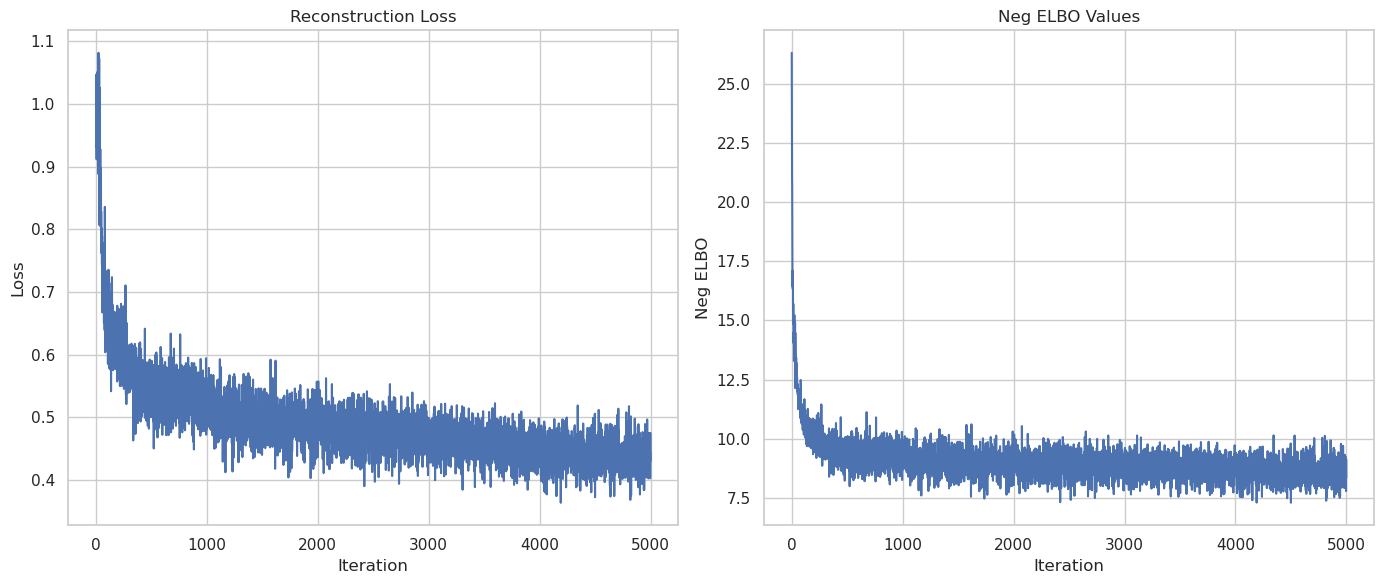

In [97]:
plot_recon_elbo(recon_list, loss_list, save_path="images/elbo_vs_recon.png")

In [102]:
from sklearn.metrics import roc_auc_score, mean_squared_error
scores = predict_scores(Y_test)
roc_auc_score(lb_test, scores["elbo"]) , roc_auc_score(lb_test, scores["recon"])

/tmp/ipykernel_10951/872168708.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.float32)


(0.9637345679012346, 0.9441068672839507)